# LINEAR SVM

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import libsvm
from libsvm.svmutil import *

%matplotlib inline

## 3.1 Linear Support Vector Machine on toy data

### 3.1.1 
Generate a training set of size $100$ with 2D features (X) drawn at random as follows:
* X_{neg} $\sim$ $\mathcal{N}$([-5, -5], 5*$I_2$) and correspond to negative labels (-1)
* X_{pos} $\sim$ $\mathcal{N}$([5, 5], 5*$I_2$) and correspond to positive labels (+1)
<br />
Accordingly, $X = [X_{neg}, X_{pos}]$ is a $100\times2$ array, Y is a $100\times1$ array of values $\in \{-1, 1\}$.
<p/>Draw a scatter plot of the full training dataset with the points colored according to their labels.

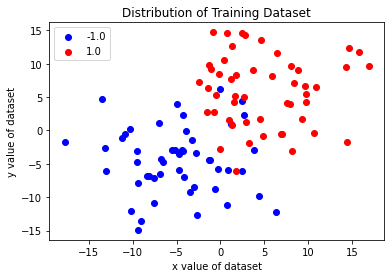

In [135]:
# Generate binary class dataset
np.random.seed(0)

n_samples = 100
center_1 = [-5, -5]
center_2 = [5, 5]

# Generate Data:
Xneg = np.random.normal(center_1,5,size=(50,2))
Xpos = np.random.normal(center_2,5,size=(50,2))
X = np.concatenate((Xneg, Xpos), axis=0)
#Y = np.array([-1]*50,[1]*50)
#Y = np.reshape(Y,(100,1))
np.concatenate((-1*np.ones(50),np.ones(50)), axis=0)

#print(Xneg)
#print(Xpos)

# Scatter plot:
fig, ax = plt.subplots()
plt.title("Distribution of Training Dataset")
plt.xlabel("x value of dataset")
plt.ylabel("y value of dataset")
cdict = {-1: 'blue', 1: 'red'}
unique_Y = np.unique(Y)
for g in unique_Y:
    wx = np.where(Y == g)
    ax.scatter(X[wx,0], X[wx,1], c = cdict[g], label = g)
    ax.legend()
plt.show()

### 3.1.2 
Train a linear support vector machine on the data with $C=1$ and draw the decision boundary line that separates o and x. Mark the support vectors separately (ex.circle around the point). 

Note: You can use the libsvm.svmutil functions with the kernel_type set to 0, indiciating a linear kernel and svm_type set to 0 indicating C-SVC.
Also note that the support_vector coefficients returned by the LIBSVM model are the dual coefficients.

Accuracy = 93% (93/100) (classification)


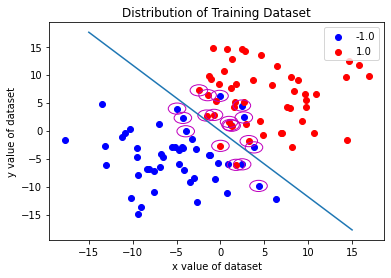

In [139]:
# Define the SVM problem
prob = svm_problem(Y,X)

# Define the hyperparameters
param = svm_parameter('-s 0 -t 0 -c 1')

# Train the model
model = svm_train(prob, param)

# Compute the slope and intercept of the separating line/hyperplanee with the use of the support vectors
# and other information from the LIBSVM model.
p_labs, p_acc, p_vals = svm_predict(Y, X, model)

w = np.matmul(X[np.array(model.get_sv_indices()) - 1].T, model.get_sv_coef())
b = -model.rho.contents.value

# Draw the scatter plot, the decision boundary line, and mark the support vectors.

space_x = np.linspace(-15, 15, 100)

cdict = {-1: 'blue', 1: 'red'}
fig, ax = plt.subplots()
plt.title("Distribution of Training Dataset")
plt.xlabel("x value of dataset")
plt.ylabel("y value of dataset")

for g in np.unique(Y):
    wx = np.where(Y == g)
    ax.scatter(X[wx,0], X[wx,1], c = cdict[g], label = g)
    
plt.plot(dummy_x, (-w[0]/w[1])*dummy_x-(b/w[1]))

for i in model.get_sv_indices():
    circle = plt.Circle((X[i-1,0], X[i-1,1]),1,color='m', fill = False)
    ax.add_patch(circle)


ax.legend()
plt.show()

### 3.1.3 
Draw a line that separates the data for 8 different $C$ ($10^{-5}$~$10^7$).
Plot the number of support vectors vs. $C$ (plot x-axis on a log scale).
How does the number of support vectors change as $C$ increases and why does it change like that? 

Note: You might prefer to use the command-line style of svm_parameter initialization such as: svm_parameter('-s 0 -t 0') to indicate a linear kernel and C-SVC as the SVM type.


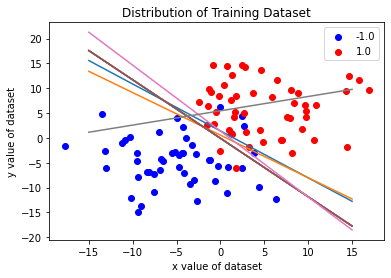

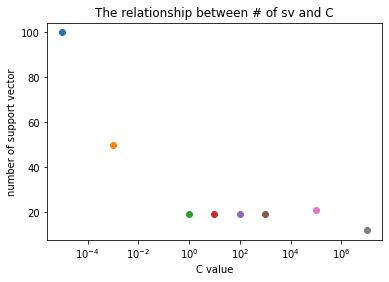

In [155]:

C_range = [10**-5, 10**-3, 1, 10, 100, 10**3, 10**5, 10**7]
num_sv = []
coefficient_data = []

# Loop over a similar setup to that in the previous code block.
for i in range(len(C_range)):
    prob = svm_problem(Y,X)
    param = svm_parameter('-s 0 -t 0 -c {}'.format(C_range[i]))
    model = svm_train(prob, param)
    
    rho=model.rho[0]
    w = np.matmul(X[np.array(model.get_sv_indices()) - 1].T, model.get_sv_coef())
    b = -model.rho.contents.value
    
    num_sv.append(len(model.get_sv_indices()))
    coefficient_data.append(((-w[0]/w[1]),-(b/w[1])))
    
# Draw the scatter plot with multiple decision lines on top (one for each value of C)
space_x = np.linspace(-15, 15, 100)

cdict = {-1: 'blue', 1: 'red'}
fig, ax = plt.subplots()
plt.title("Distribution of Training Dataset")
plt.xlabel("x value of dataset")
plt.ylabel("y value of dataset")

for g in np.unique(Y):
    wx = np.where(Y == g)
    ax.scatter(X[wx,0], X[wx,1], c = cdict[g], label = g)

for i in range(len(coefficient_data)):
    plt.plot(space_x, coefficient_data[i][0]*space_x+coefficient_data[i][1])
    
ax.legend()
plt.show()

# Draw the num_sv vs. C plot.

fig, ax = plt.subplots()
plt.title("The relationship between # of sv and C")
plt.xlabel("C value")
plt.ylabel("number of support vector")
for i in range(len(C_range)):
    ax.set_xscale('log')
    ax.scatter(C_range[i], num_sv[i])

plt.show()

The number of support vectors decreses as C value increases. If C value is increased, there should be a greater penalty of the constraint. The size of violations is reduced, and it causes the margin will get narrower. Therefore, there are fewer support vectors by increasing C value.

### 3.1.4 
Now try rescaling the data to the [0,1] range and repeat the steps of the previous question (3.1.3) and over the same range of $C$ values. Are the decision boundaries different from those in the previous question? What does this imply about (a) the geometric margin and (b) the relative effect of each feature on the predictions of the trained model ?

In [157]:
import sklearn
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

# Single line below:
X_train_minmax = min_max_scaler.fit_transform(X)

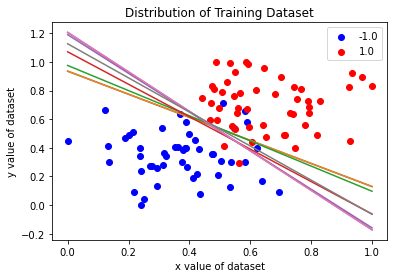

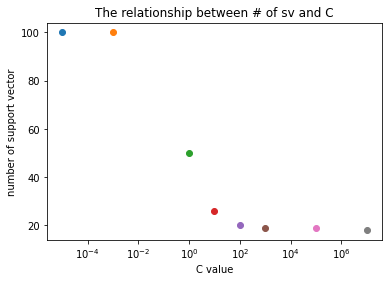

In [160]:
C_range = [10**-5, 10**-3, 1, 10, 100, 10**3, 10**5, 10**7]
num_sv = []
coefficient_data = []

# Repeat the loop from 3.1.3 

# Loop over a similar setup to that in the previous code block.
for i in range(len(C_range)):
    prob = svm_problem(Y,X_train_minmax)
    param = svm_parameter('-s 0 -t 0 -c {}'.format(C_range[i]))
    model = svm_train(prob, param)
    
    rho=model.rho[0]
    w = np.matmul(X_train_minmax[np.array(model.get_sv_indices()) - 1].T, model.get_sv_coef())
    b = -model.rho.contents.value
    
    num_sv.append(len(model.get_sv_indices()))
    coefficient_data.append(((-w[0]/w[1]),-(b/w[1])))
    
# Draw the scatter plot with multiple decision lines on top (one for each value of C)
space_x = np.linspace(0, 1, 100)

cdict = {-1: 'blue', 1: 'red'}
fig, ax = plt.subplots()
plt.title("Distribution of Training Dataset")
plt.xlabel("x value of dataset")
plt.ylabel("y value of dataset")

for g in np.unique(Y):
    wx = np.where(Y == g)
    ax.scatter(X_train_minmax[wx,0], X_train_minmax[wx,1], c = cdict[g], label = g)

for i in range(len(coefficient_data)):
    plt.plot(space_x, coefficient_data[i][0]*space_x+coefficient_data[i][1])
    
ax.legend()
plt.show()

# Draw the num_sv vs. C plot.

fig, ax = plt.subplots()
plt.title("The relationship between # of sv and C")
plt.xlabel("C value")
plt.ylabel("number of support vector")
for i in range(len(C_range)):
    ax.set_xscale('log')
    ax.scatter(C_range[i], num_sv[i])

plt.show()

The decision boundaries for this section are different from those on the previous section. It is because the boundary of x value is different. In this problem, the range [0,1] has been used unlike the range of [-15,15] for the last section. Geometrically, the margins between points are smaller, it makes the prediction harder to decide than the previeous geometrical margin.

## *Penguins*



```
# This is formatted as code
```

Multiclass SVM. In this problem, we will use support vector machines to classify penguins species based on the given features.

### 
Load in the penguins data using from the provided penguins.csv file on Sakai. Preprocess the features. Then we will use the train_test_split from sklearn to split the data into training and testing into a 0.8 : 0.2 ratio.

In [172]:
import pandas as pd
from sklearn.model_selection import train_test_split

# load data
df = pd.read_csv('penguins.csv')
print(df.head())

# split data
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Species'], axis=1).to_numpy(), df['Species'].to_numpy(), test_size=0.2, random_state=1)

   CulmenLength  CulmenDepth  FlipperLength  BodyMass  Species
0          39.1         18.7          181.0    3750.0        0
1          39.5         17.4          186.0    3800.0        0
2          40.3         18.0          195.0    3250.0        0
3           NaN          NaN            NaN       NaN        0
4          36.7         19.3          193.0    3450.0        0


Train the support vector machine classifier with a linear kernel on the first 5000 datapoints and test the accuracy on the following 5000 points.
Plot test accuracy and the number of support vectors (two separate plots) vs. $C$ for $C=10^{-12}$~$10^{12}$ (plot 7 points or more with the x-axis on a log scale). 

Accuracy = 28.9855% (20/69) (classification)
Accuracy = 69.5652% (48/69) (classification)
Accuracy = 92.7536% (64/69) (classification)
Accuracy = 94.2029% (65/69) (classification)
Accuracy = 95.6522% (66/69) (classification)
Accuracy = 95.6522% (66/69) (classification)
Accuracy = 95.6522% (66/69) (classification)


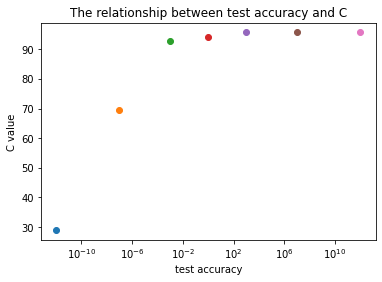

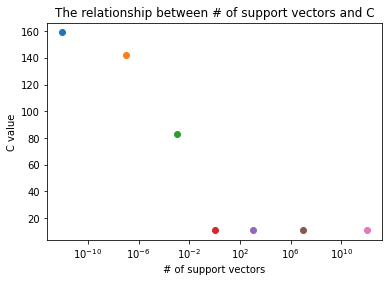

In [173]:
C_range = [10**-12, 10**-7, 10**-3, 1, 10**3, 10**7, 10**12]

num_sv = []
ans = []
accuracy = []

# Loop over a similar setup to that in the previous code block.
for i in range(len(C_range)):
    prob = svm_problem(y_train,X_train)
    param = svm_parameter('-s 0 -t 0 -c {}'.format(C_range[i]))
    model = svm_train(prob, param)
    
    rho=model.rho[0]
    w = np.matmul(X_train[np.array(model.get_sv_indices()) - 1].T, model.get_sv_coef())
    b = -model.rho.contents.value
    
    p_labels, p_acc, p_vals = svm_predict(y_test, X_test, model)
    num_sv.append(len(model.get_sv_indices()))
    accuracy.append(p_acc)

for i in range(len(accuracy)):
    ans.append(accuracy[i][0])

# Draw the scatter plot with multiple decision lines on top (one for each value of C)
space_x = np.linspace(-15, 15, 100)

fig, ax = plt.subplots()
plt.title("The relationship between test accuracy and C")
plt.xlabel("test accuracy")
plt.ylabel("C value")
for i in range(len(C_range)):
    ax.scatter(C_range[i], ans[i])
    ax.set_xscale('log')
plt.show

# Draw the num_sv vs. C plot.
fig, ax = plt.subplots()
plt.title("The relationship between # of support vectors and C")
plt.xlabel("# of support vectors")
plt.ylabel("C value")
for i in range(len(C_range)):
    ax.scatter(C_range[i], num_sv[i])
    ax.set_xscale('log')
plt.show()

Calculate variable importance (CulmenLength, CulmenDepth, FlipperLength, BodyMass) with your classifier. Rank these variables/ features from most important to the least important. Utilize three strategies covered in the class:
* model reliance
* conditional model reliance
* algorithm reliance

Do all three give the same result?


In [175]:
# Model Reliance

for i in range(len(C_range)):
    prob = svm_problem(y_train,X_train)
    param = svm_parameter('-s 0 -t 0 -c {}'.format(C_range[i]))
    model = svm_train(prob, param)
    
    rho=model.rho[0]
    w = np.matmul(X_train[np.array(model.get_sv_indices()) - 1].T, model.get_sv_coef())
    b = -model.rho.contents.value
    
    p_labels, p_acc, p_vals = svm_predict(y_test, X_test, model)
    
    for i = 1:len('CulmenLength')
        pi = 

print(p_labels)

Accuracy = 28.9855% (20/69) (classification)
Accuracy = 69.5652% (48/69) (classification)
Accuracy = 92.7536% (64/69) (classification)
Accuracy = 94.2029% (65/69) (classification)
Accuracy = 95.6522% (66/69) (classification)
Accuracy = 95.6522% (66/69) (classification)
Accuracy = 95.6522% (66/69) (classification)
[2.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0]
